Načítanie knížnic

In [2000]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import glob

from sklearn.model_selection import train_test_split

import scipy as sc
from pandas import read_csv

import math 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import glob

import scipy as sc
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix

Načítanie datasetu

In [2001]:
original_data = pd.read_csv("ElectricCarData_Clean.csv")
data = pd.read_csv("ElectricCarData_Clean.csv")

### Funkcie

Úprava stĺpcov a nahradenie invalidnej hodnoty

In [2002]:
def EditColumns(data):
    data = data.drop(['PlugType'], axis = 1)

    data['FastCharge_KmH'] = data['FastCharge_KmH'].astype(str).str.replace('-','0')
    data['FastCharge_KmH'] = data['FastCharge_KmH'].astype(float)

    data.columns = data.columns.str.replace('AccelSec', 'Acceleration 0-100 (s)')
    data.columns = data.columns.str.replace('TopSpeed_KmH', 'TopSpeed (km/h)')
    data.columns = data.columns.str.replace('Range_Km', 'Range (km)')
    data.columns = data.columns.str.replace('Efficiency_WhKm', 'Efficiency (Wh/km)')
    data.columns = data.columns.str.replace('FastCharge_KmH', 'FastCharge (km/h)')
    return data

In [2003]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [2004]:
def identify_outliers(data):
    lower = data.quantile(0.25) - 1.5 * stats.iqr(data)
    upper = data.quantile(0.75) + 1.5 * stats.iqr(data)
    
    return data[(data > upper) | (data < lower)]

In [2005]:
data = EditColumns(data)

Ukážka datasetu

In [2006]:
data.head()

,Brand,Model,Acceleration 0-100 (s),TopSpeed (km/h),Range (km),Efficiency (Wh/km),FastCharge (km/h),RapidCharge,PowerTrain,BodyStyle,Segment,Seats,PriceEuro
0,Tesla,Model 3 Long Range Dual Motor,4.6,233,450,161,940.0,Yes,AWD,Sedan,D,5,55480
1,Volkswagen,ID.3 Pure,10.0,160,270,167,250.0,Yes,RWD,Hatchback,C,5,30000
2,Polestar,2,4.7,210,400,181,620.0,Yes,AWD,Liftback,D,5,56440
3,BMW,iX3,6.8,180,360,206,560.0,Yes,RWD,SUV,D,5,68040
4,Honda,e,9.5,145,170,168,190.0,Yes,RWD,Hatchback,B,4,32997


Informácie o datasete

In [2007]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Brand                   103 non-null    object 
 1   Model                   103 non-null    object 
 2   Acceleration 0-100 (s)  103 non-null    float64
 3   TopSpeed (km/h)         103 non-null    int64  
 4   Range (km)              103 non-null    int64  
 5   Efficiency (Wh/km)      103 non-null    int64  
 6   FastCharge (km/h)       103 non-null    float64
 7   RapidCharge             103 non-null    object 
 8   PowerTrain              103 non-null    object 
 9   BodyStyle               103 non-null    object 
 10  Segment                 103 non-null    object 
 11  Seats                   103 non-null    int64  
 12  PriceEuro               103 non-null    int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 10.6+ KB


Dataset má 103 riadkov a 14 stĺpcov.

Dataset je zložený z atribútov:
- 6 spojitých
    - 1x float
    - 5x int
- 8 kategorických
    - 8x object
    
Nenachádzajú sa tu nulové hodnoty.

Deskriptívne štatistiky datasetu

In [2008]:
data.describe()

,Acceleration 0-100 (s),TopSpeed (km/h),Range (km),Efficiency (Wh/km),FastCharge (km/h),Seats,PriceEuro
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,7.396117,179.194175,338.786408,189.165049,434.563107,4.883495,55811.563107
std,3.017430,43.573030,126.014444,29.566839,219.660061,0.795834,34134.665280
min,2.100000,123.000000,95.000000,104.000000,0.000000,2.000000,20129.000000
25%,5.100000,150.000000,250.000000,168.000000,260.000000,5.000000,34429.500000
50%,7.300000,160.000000,340.000000,180.000000,440.000000,5.000000,45000.000000
75%,9.000000,200.000000,400.000000,203.000000,555.000000,5.000000,65000.000000
max,22.400000,410.000000,970.000000,273.000000,940.000000,7.000000,215000.000000


In [2009]:
# A	mini
# B	small
# C	medium
# D	large
# E	executive
# F	luxury

# J	SUV
# M	MPV

# N	VAN
# S	sports

In [2010]:
# A watt hour per kilometer (Wh/km) measures how many watt hours of electricity a car consumes to travel distance of 1 kilometer.
# 1 Wh/km = 1 000 km/kWh

In [2011]:
data.isnull().sum()

Brand                     0
Model                     0
Acceleration 0-100 (s)    0
TopSpeed (km/h)           0
Range (km)                0
Efficiency (Wh/km)        0
FastCharge (km/h)         0
RapidCharge               0
PowerTrain                0
BodyStyle                 0
Segment                   0
Seats                     0
PriceEuro                 0
dtype: int64

In [2012]:
def ReplaceStringValues(data):
    data['PowerTrain'] = data['PowerTrain'].astype(str).str.replace('AWD','3')
    data['PowerTrain'] = data['PowerTrain'].astype(str).str.replace('RWD','2')
    data['PowerTrain'] = data['PowerTrain'].astype(str).str.replace('FWD','1')
    data['PowerTrain'] = data['PowerTrain'].astype(int)

    data['RapidCharge'] = data['RapidCharge'].astype(str).str.replace('Yes','1')
    data['RapidCharge'] = data['RapidCharge'].astype(str).str.replace('No','0')
    data['RapidCharge'] = data['RapidCharge'].astype(int)

    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Hatchback','1')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Liftback','2')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Sedan','3')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Station','4')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Cabrio','5')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('SUV','6')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('MPV','7')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('SPV','8')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Pickup','9')
    data['BodyStyle'] = data['BodyStyle'].astype(int)

    data['Segment'] = data['Segment'].astype(str).str.replace('A','1')
    data['Segment'] = data['Segment'].astype(str).str.replace('B','2')
    data['Segment'] = data['Segment'].astype(str).str.replace('C','3')
    data['Segment'] = data['Segment'].astype(str).str.replace('D','4')
    data['Segment'] = data['Segment'].astype(str).str.replace('E','5')
    data['Segment'] = data['Segment'].astype(str).str.replace('F','6')
    data['Segment'] = data['Segment'].astype(str).str.replace('N','7')
    data['Segment'] = data['Segment'].astype(str).str.replace('S','8')
    data['Segment'] = data['Segment'].astype(int)

    # data.drop(data.index[data['BodyStyle'] == 0], inplace=True)
    # data.drop(data.index[data['BodyStyle'] == 1], inplace=True)
    # data.drop(data.index[data['BodyStyle'] == 2], inplace=True)
    # data.drop(data.index[data['BodyStyle'] == 3], inplace=True)
    # data.drop(data.index[data['BodyStyle'] == 4], inplace=True)
    # data.drop(data.index[data['BodyStyle'] == 7], inplace=True)
    # data.drop(data.index[data['BodyStyle'] == 6], inplace=True)
    # data.drop(data.index[data['BodyStyle'] == 8], inplace=True)
    return data

In [2013]:
data = ReplaceStringValues(data)

In [2014]:
normalized_data = data
# for column in data.columns:
#     if(column != 'Brand' and column != 'Model' and column != 'PowerTrain' and 
#        column != 'RapidCharge' and column != 'BodyStyle' and column != 'Segment'):
#         normalized_data[column]  = NormalizeData(data[column])

In [2015]:
# fig, ax = plt.subplots(figsize = (20, 16))
# sns.heatmap(normalized_data.corr(), ax = ax, annot = True, fmt = ".3f")

In [2016]:
# train, test = train_test_split(data, test_size=0.3, random_state=65)

In [2017]:
# train.info()

In [2018]:
# sns.pairplot(normalized_data)

In [2019]:
# sns.pairplot(normalized_data, hue = "PowerTrain")

# 1. hypotéza 
Vozidla, ktore maju pohananu len 1 napravu (FWD / RWD), majú zrýchlenie z 0-100 dlhsie ako 8 sekund.

C:\Users\Martin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PowerTrain', ylabel='Acceleration 0-100 (s)'>

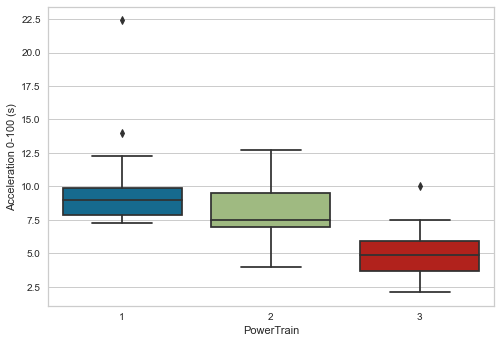

In [2020]:
sns.boxplot("PowerTrain", "Acceleration 0-100 (s)", data=normalized_data)

In [2021]:
Acceleration_FWD = normalized_data.loc[normalized_data['PowerTrain']==1, 'Acceleration 0-100 (s)']
Acceleration_RWD = normalized_data.loc[normalized_data['PowerTrain']==2, 'Acceleration 0-100 (s)']
Acceleration_AWD = normalized_data.loc[normalized_data['PowerTrain']==3, 'Acceleration 0-100 (s)']
Acceleration_FRWD = Acceleration_FWD
Acceleration_FRWD = Acceleration_FRWD.append(Acceleration_RWD)

C:\Users\Martin\AppData\Local\Temp\ipykernel_18748\255953600.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Acceleration_FRWD = Acceleration_FRWD.append(Acceleration_RWD)


C:\Users\Martin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Acceleration 0-100 (s)', ylabel='Density'>

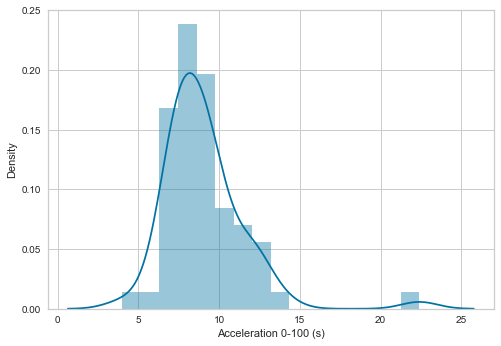

In [2022]:
sns.distplot(Acceleration_FRWD)

C:\Users\Martin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Acceleration 0-100 (s)', ylabel='Density'>

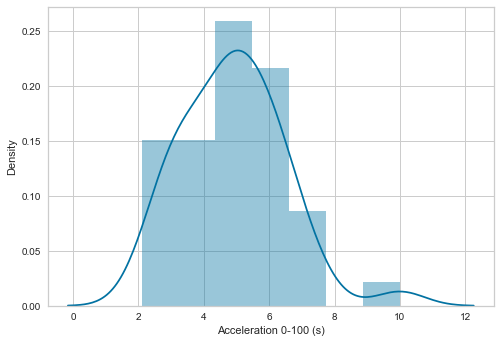

In [2023]:
sns.distplot(Acceleration_AWD)

In [2024]:
Acceleration_FRWD_outliers = identify_outliers(Acceleration_FRWD)
Acceleration_AWD_outliers = identify_outliers(Acceleration_AWD)

In [2025]:
Acceleration_FRWD = Acceleration_FRWD.drop(Acceleration_FRWD_outliers.index)
Acceleration_AWD = Acceleration_AWD.drop(Acceleration_AWD_outliers.index)

C:\Users\Martin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Acceleration 0-100 (s)', ylabel='Density'>

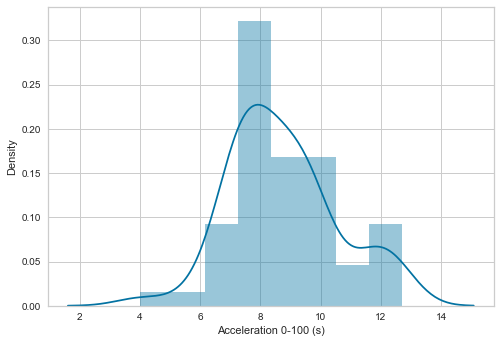

In [2026]:
sns.distplot(Acceleration_FRWD)

C:\Users\Martin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Acceleration 0-100 (s)', ylabel='Density'>

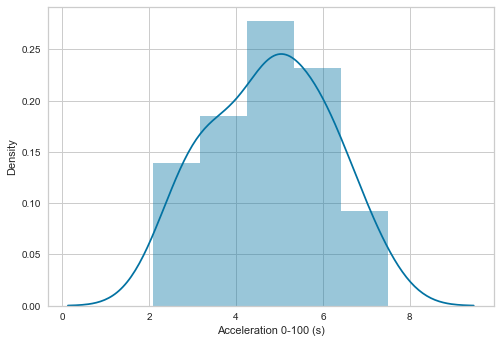

In [2027]:
sns.distplot(Acceleration_AWD)

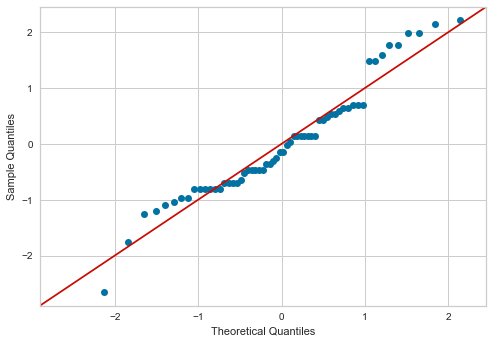

In [2028]:
_ = sm.ProbPlot(Acceleration_FRWD, fit=True).qqplot(line='45')

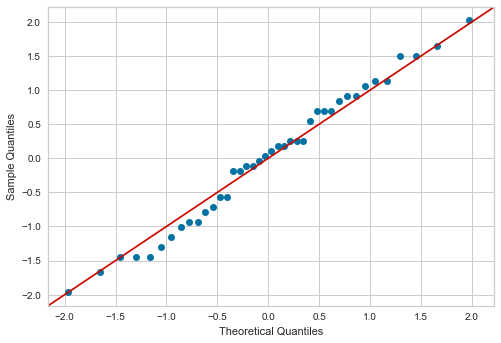

In [2029]:
_ = sm.ProbPlot(Acceleration_AWD, fit=True).qqplot(line='45')

In [2030]:
# As the p_value for the given problem is more than 0.05 which is the alpha value, 
# we accept the null hypothesis and the alternative hypothesis is rejected.

Test normalneho rozdelenia

In [2031]:
stats.shapiro(Acceleration_AWD)

ShapiroResult(statistic=0.9782707691192627, pvalue=0.6255438327789307)

In [2032]:
stats.shapiro(Acceleration_FRWD)

ShapiroResult(statistic=0.9542449712753296, pvalue=0.02477077767252922)

Keďže je p < 0.05, nulovú hypotézu zamietame a dáta pravdepodobne pochádzajú z iného ako normálneho rozdelenia.

In [2033]:
# The test is not significant meaning there is homogeneity of variances and we can proceed.

In [2034]:
stats.levene(Acceleration_AWD, Acceleration_FRWD)

LeveneResult(statistic=1.924711880609703, pvalue=0.1684850720280431)

Kedže je p > 0.05 znamená to, že všetky vstupné vzorky pochádzajú z rozdelení s rovnakými varianciami.

Nesplil sa predpoklad t-testu, preto použijeme Mann-Whiteneyho U-test

In [2035]:
stats.mannwhitneyu(Acceleration_FRWD,Acceleration_AWD)

MannwhitneyuResult(statistic=2336.0, pvalue=1.3116062672076907e-15)

### Keďže je p < 0.05, nulovú hypotézu zamietame 

Rovnaká hypotéza, ale dáta sú kvôli normálnosti rozdelenia zlogaritmované

In [2036]:
Acceleration_FWD = normalized_data.loc[normalized_data['PowerTrain']==1, 'Acceleration 0-100 (s)']
Acceleration_RWD = normalized_data.loc[normalized_data['PowerTrain']==2, 'Acceleration 0-100 (s)']
Acceleration_AWD = normalized_data.loc[normalized_data['PowerTrain']==3, 'Acceleration 0-100 (s)']
Acceleration_FRWD = Acceleration_FWD
Acceleration_FRWD = Acceleration_FRWD.append(Acceleration_RWD)

Acceleration_FRWD = (np.log(Acceleration_FRWD))
Acceleration_AWD = (np.log(Acceleration_AWD))

C:\Users\Martin\AppData\Local\Temp\ipykernel_18748\2442403853.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Acceleration_FRWD = Acceleration_FRWD.append(Acceleration_RWD)


In [2037]:
Acceleration_FRWD_outliers = identify_outliers(Acceleration_FRWD)
Acceleration_AWD_outliers = identify_outliers(Acceleration_AWD)

In [2038]:
Acceleration_FRWD = Acceleration_FRWD.drop(Acceleration_FRWD_outliers.index)
Acceleration_AWD = Acceleration_AWD.drop(Acceleration_AWD_outliers.index)

C:\Users\Martin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Acceleration 0-100 (s)', ylabel='Density'>

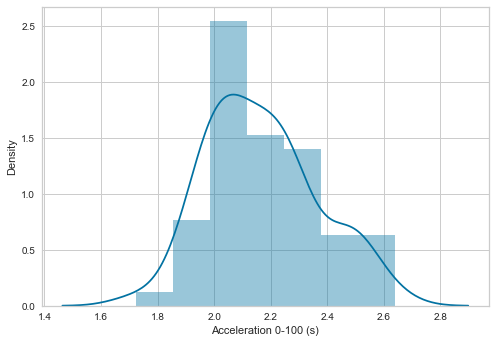

In [2039]:
sns.distplot(Acceleration_FRWD)

C:\Users\Martin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Acceleration 0-100 (s)', ylabel='Density'>

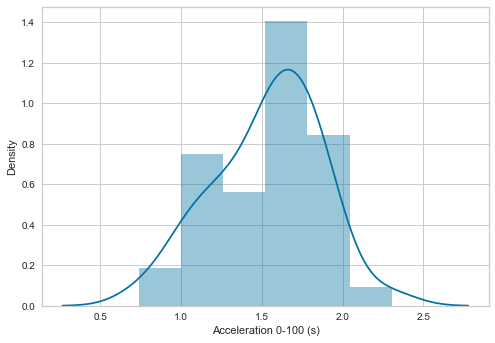

In [2040]:
sns.distplot(Acceleration_AWD)

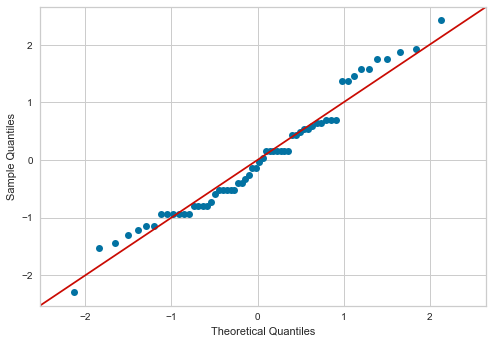

In [2041]:
_ = sm.ProbPlot(Acceleration_FRWD, fit=True).qqplot(line='45')

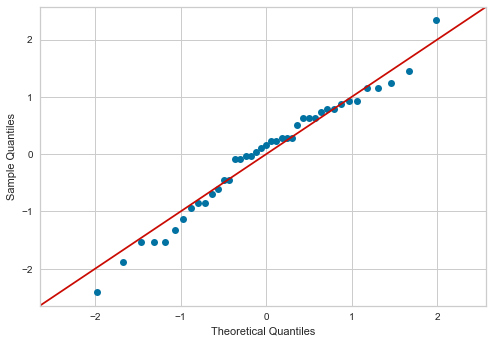

In [2042]:
_ = sm.ProbPlot(Acceleration_AWD, fit=True).qqplot(line='45')

Logistická regresia

Skúmame, ako dobre vieme predikovať hodnoty akcelerácie pre vozidlá s rôznym pohonom.

In [2043]:
logRegData = data
logRegData['PowerTrain'].replace(to_replace=['AWD','FWD','RWD'], value = [0, 1, 2], inplace = True)
y = data[['PowerTrain']]
x = data[['Acceleration 0-100 (s)']]

Rozdelíme si dáta na trénovaciu a testovaciu časť.

In [2044]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 50)

Natrénovanie logistickej regresie

In [2045]:
log = LogisticRegression()
log.fit(x_train, y_train.values.ravel())
prediction = log.predict(x_test)

Vypočítanie chyby RMSE

In [2046]:
rmse = np.sqrt(mean_squared_error(y_test, prediction))
print("Error: ", rmse)

Error:  0.511766315719159


Vypočítanie skóre R2

In [2047]:
r2 = (r2_score(y_test, prediction))
print("R2 score: ", r2)

R2 score:  0.6382145653876272


Vypočítanie úspešnosti modelu pomocou accuracy score

In [2048]:
score = accuracy_score(y_test, prediction)
print("Accuracy score: ", score)

Accuracy score:  0.7380952380952381


Zobrazenie confusion matice

In [2049]:
confusion_matrix(y_test, prediction)

array([[13,  0,  0],
       [ 8,  0,  3],
       [ 0,  0, 18]], dtype=int64)

Na základe logistickej regresie sa zdá model relatívne dobrý, preto ešte hypotézu nezamietame a prejdeme na vykonávanie testov.

In [2050]:
stats.shapiro(Acceleration_AWD)

ShapiroResult(statistic=0.9778589606285095, pvalue=0.5951706767082214)

In [2051]:
stats.shapiro(Acceleration_FRWD)

ShapiroResult(statistic=0.9684750437736511, pvalue=0.12283243983983994)

Keďže je p > 0.05, nulovú hypotézu nezamietame a dáta pravdepodobne pochádzajú z normálneho rozdelenia.

In [2052]:
stats.levene(Acceleration_AWD, Acceleration_FRWD)

LeveneResult(statistic=9.741976719175183, pvalue=0.0023607444005539395)

Kedže je p < 0.05 znamená to, že všetky vstupné vzorky pochádzajú z rozdelení s rôznymi varianciami. Nemôžeme teda použit t-test, ale použijeme Mann-Whiteneyho U-test

In [2053]:
# Reject null hypothesis >> The variances of the samples are different

In [2054]:
stats.mannwhitneyu(Acceleration_FRWD,Acceleration_AWD)

MannwhitneyuResult(statistic=2374.5, pvalue=2.465012702210641e-15)

### Keďže je p < 0.05, nulovú hypotézu zamietame 

In [2055]:
Acceleration_FRWD.describe()

count    60.000000
mean      2.168615
std       0.195868
min       1.722767
25%       2.014903
50%       2.151695
75%       2.284920
max       2.639057
Name: Acceleration 0-100 (s), dtype: float64

In [2056]:
(2.17-8)/(1.80334/math.sqrt(60))

-25.041858893374787

In [2057]:
sc.stats.ttest_1samp(Acceleration_FRWD, 8, alternative='less')

Ttest_1sampResult(statistic=-230.61306494315025, pvalue=3.385753164818304e-89)

In [2058]:
# T test table value 1.6711

In [2059]:
# https://towardsdatascience.com/hypothesis-testing-with-python-step-by-step-hands-on-tutorial-with-practical-examples-e805975ea96e

# 2. hypotéza 
Vozidla kategorie SUV maju priemerne vyssiu spotrebu energie ako vozidla inych kategórii

C:\Users\Martin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='BodyStyle', ylabel='Efficiency (Wh/km)'>

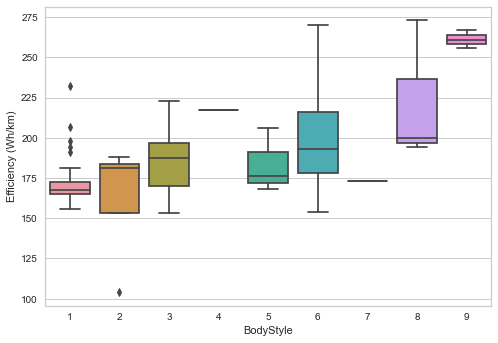

In [2060]:
sns.boxplot("BodyStyle", "Efficiency (Wh/km)", data=normalized_data)

In [2061]:
Hatchback = normalized_data.loc[normalized_data['BodyStyle']==1, 'Efficiency (Wh/km)']
Liftback = normalized_data.loc[normalized_data['BodyStyle']==2, 'Efficiency (Wh/km)']
Sedan = normalized_data.loc[normalized_data['BodyStyle']==3, 'Efficiency (Wh/km)']
Station = normalized_data.loc[normalized_data['BodyStyle']==4, 'Efficiency (Wh/km)']
Cabrio = normalized_data.loc[normalized_data['BodyStyle']==5, 'Efficiency (Wh/km)']
SUV = normalized_data.loc[normalized_data['BodyStyle']==6, 'Efficiency (Wh/km)']
MPV = normalized_data.loc[normalized_data['BodyStyle']==7, 'Efficiency (Wh/km)']
SPV = normalized_data.loc[normalized_data['BodyStyle']==8, 'Efficiency (Wh/km)']
Pickup = normalized_data.loc[normalized_data['BodyStyle']==9, 'Efficiency (Wh/km)']

Other_BodyStyles = Hatchback
Other_BodyStyles = Other_BodyStyles.append(Liftback)
Other_BodyStyles = Other_BodyStyles.append(Sedan)
Other_BodyStyles = Other_BodyStyles.append(Station)
Other_BodyStyles = Other_BodyStyles.append(Cabrio)
Other_BodyStyles = Other_BodyStyles.append(MPV)
Other_BodyStyles = Other_BodyStyles.append(SPV)
Other_BodyStyles = Other_BodyStyles.append(Pickup)

# SUV = np.log(SUV)
# Other_BodyStyles = np.log(Other_BodyStyles)

C:\Users\Martin\AppData\Local\Temp\ipykernel_18748\1451376620.py:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Other_BodyStyles = Other_BodyStyles.append(Liftback)
C:\Users\Martin\AppData\Local\Temp\ipykernel_18748\1451376620.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Other_BodyStyles = Other_BodyStyles.append(Sedan)
C:\Users\Martin\AppData\Local\Temp\ipykernel_18748\1451376620.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Other_BodyStyles = Other_BodyStyles.append(Station)
C:\Users\Martin\AppData\Local\Temp\ipykernel_18748\1451376620.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Other_BodyStyles = Other_

In [2062]:
Other_BodyStyles.info()

<class 'pandas.core.series.Series'>
Int64Index: 58 entries, 1 to 86
Series name: Efficiency (Wh/km)
Non-Null Count  Dtype
--------------  -----
58 non-null     int64
dtypes: int64(1)
memory usage: 928.0 bytes


In [2063]:
SUV.info()

<class 'pandas.core.series.Series'>
Int64Index: 45 entries, 3 to 102
Series name: Efficiency (Wh/km)
Non-Null Count  Dtype
--------------  -----
45 non-null     int64
dtypes: int64(1)
memory usage: 720.0 bytes


C:\Users\Martin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Efficiency (Wh/km)', ylabel='Density'>

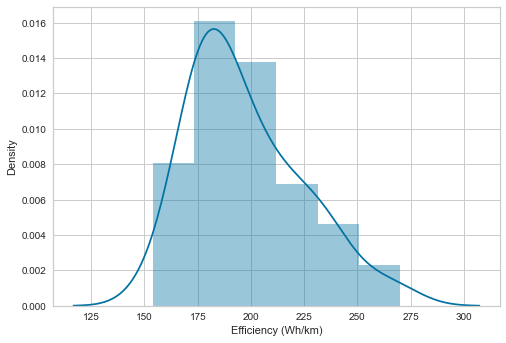

In [2064]:
sns.distplot(SUV)

C:\Users\Martin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Efficiency (Wh/km)', ylabel='Density'>

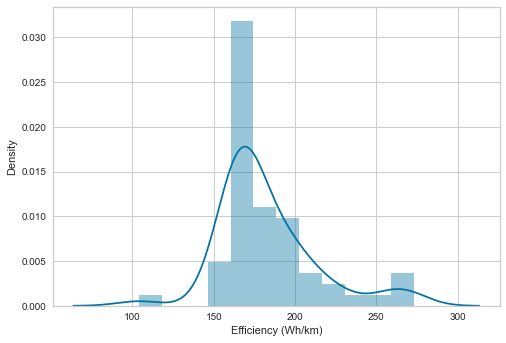

In [2065]:
sns.distplot(Other_BodyStyles)

In [2066]:
SUV_outliers = identify_outliers(SUV)
Other_BodyStyles_outliers = identify_outliers(Other_BodyStyles)

In [2067]:
SUV = SUV.drop(SUV_outliers.index)
Other_BodyStyles = Other_BodyStyles.drop(Other_BodyStyles_outliers.index)

C:\Users\Martin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Efficiency (Wh/km)', ylabel='Density'>

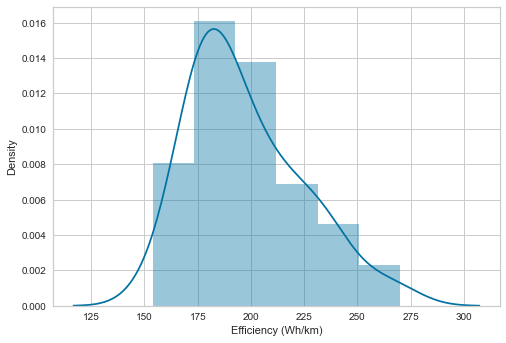

In [2068]:
sns.distplot(SUV)

C:\Users\Martin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Efficiency (Wh/km)', ylabel='Density'>

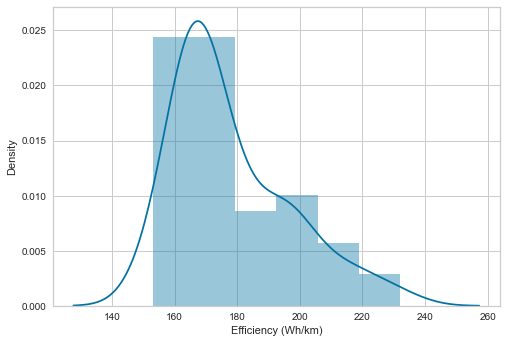

In [2069]:
sns.distplot(Other_BodyStyles)

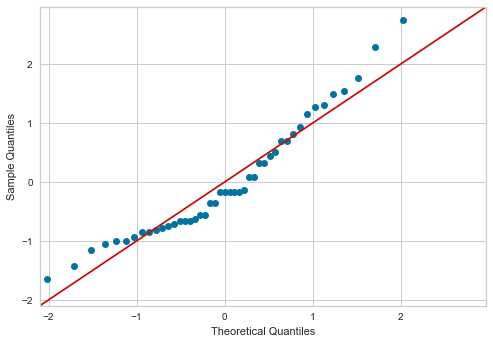

In [2070]:
_ = sm.ProbPlot(SUV, fit=True).qqplot(line='45')

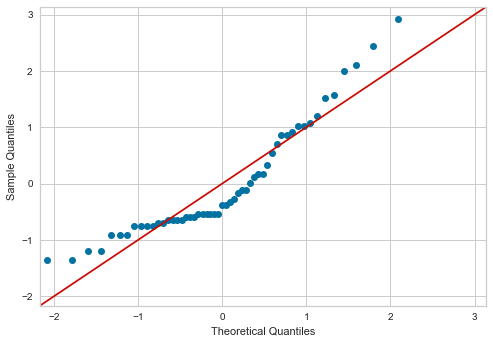

In [2071]:
_ = sm.ProbPlot(Other_BodyStyles, fit=True).qqplot(line='45')

In [2072]:
stats.levene(SUV, Other_BodyStyles)

LeveneResult(statistic=4.635305135055515, pvalue=0.03382649886020115)

In [2073]:
stats.shapiro(SUV)

ShapiroResult(statistic=0.9384679198265076, pvalue=0.018898583948612213)

In [2074]:
stats.shapiro(Other_BodyStyles)

ShapiroResult(statistic=0.8877149224281311, pvalue=0.00012637325562536716)

# Acceleration - TopSpeed

In [2075]:
km_data = data
km_data.info()
km_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Brand                   103 non-null    object 
 1   Model                   103 non-null    object 
 2   Acceleration 0-100 (s)  103 non-null    float64
 3   TopSpeed (km/h)         103 non-null    int64  
 4   Range (km)              103 non-null    int64  
 5   Efficiency (Wh/km)      103 non-null    int64  
 6   FastCharge (km/h)       103 non-null    float64
 7   RapidCharge             103 non-null    int32  
 8   PowerTrain              103 non-null    int32  
 9   BodyStyle               103 non-null    int32  
 10  Segment                 103 non-null    int32  
 11  Seats                   103 non-null    int64  
 12  PriceEuro               103 non-null    int64  
dtypes: float64(2), int32(4), int64(5), object(2)
memory usage: 9.0+ KB


,Brand,Model,Acceleration 0-100 (s),TopSpeed (km/h),Range (km),Efficiency (Wh/km),FastCharge (km/h),RapidCharge,PowerTrain,BodyStyle,Segment,Seats,PriceEuro
0,Tesla,Model 3 Long Range Dual Motor,4.6,233,450,161,940.0,1,3,3,4,5,55480
1,Volkswagen,ID.3 Pure,10.0,160,270,167,250.0,1,2,1,3,5,30000
2,Polestar,2,4.7,210,400,181,620.0,1,3,2,4,5,56440
3,BMW,iX3,6.8,180,360,206,560.0,1,2,6,4,5,68040
4,Honda,e,9.5,145,170,168,190.0,1,2,1,2,4,32997


In [2076]:
ACC_outliers = identify_outliers(km_data["Acceleration 0-100 (s)"])
km_data = km_data.drop(ACC_outliers.index)

TS_outliers = identify_outliers(km_data["TopSpeed (km/h)"])
km_data = km_data.drop(TS_outliers.index)

In [2077]:
normalized_data = data
# for column in data.columns:
#     if(column != 'Brand' and column != 'Model' and column != 'PowerTrain' and 
#        column != 'RapidCharge' and column != 'BodyStyle' and column != 'Segment'):
#         normalized_data[column]  = NormalizeData(data[column])
        
normalized_data['RapidCharge'] = normalized_data['RapidCharge'].astype(float)
normalized_data['PowerTrain'] = normalized_data['PowerTrain'].astype(float)
normalized_data['BodyStyle'] = normalized_data['BodyStyle'].astype(float)
normalized_data['Segment'] = normalized_data['Segment'].astype(float)

In [2078]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score

from sklearn.datasets import make_blobs
import pandas as pd

# make as panda dataframe for easy understanding
df = pd.DataFrame(km_data, columns=["Acceleration 0-100 (s)", "TopSpeed (km/h)"])
# df = pd.DataFrame(data, columns=["BodyStyle", "Efficiency (Wh/km)"])
df.head(2)

,Acceleration 0-100 (s),TopSpeed (km/h)
0,4.6,233
1,10.0,160


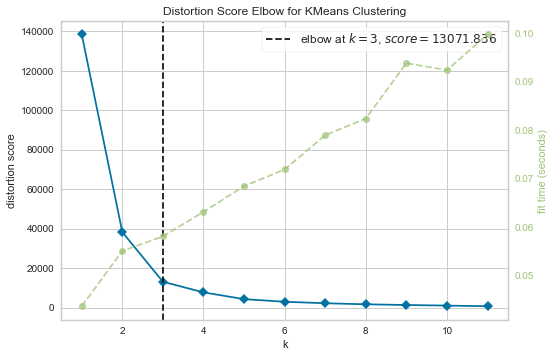

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [2079]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12)).fit(df)
visualizer.show()

In [2080]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(df)

In [2081]:
kmeans.labels_

array([1, 0, 2, 2, 0, 1, 0, 0, 1, 2, 2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2,
       0, 1, 1, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 1, 0, 2, 0,
       0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 2, 2, 1, 0,
       2, 2, 0, 0, 1, 2, 0, 0, 2, 0, 2, 1, 0, 1, 0, 2, 0, 0, 2, 2, 2, 0,
       2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2])

In [2082]:
kmeans.inertia_

13071.836440476192

In [2083]:
kmeans.n_iter_

7

In [2084]:
kmeans.cluster_centers_

array([[  9.13392857, 150.16071429],
       [  3.65333333, 248.73333333],
       [  5.7       , 192.56666667]])

In [2085]:
from collections import Counter
Counter(kmeans.labels_)

Counter({1: 15, 0: 56, 2: 30})

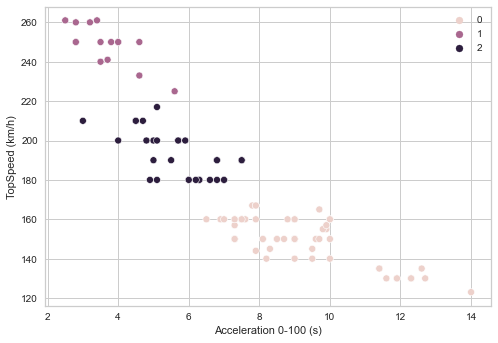

In [2086]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df, x="Acceleration 0-100 (s)", y="TopSpeed (km/h)", hue=kmeans.labels_)
# sns.scatterplot(data=df, x="BodyStyle", y="Efficiency (Wh/km)", hue=kmeans.labels_)
plt.show()

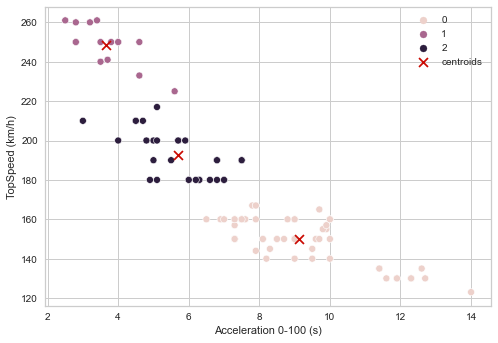

In [2087]:
sns.scatterplot(data=df, x="Acceleration 0-100 (s)", y="TopSpeed (km/h)", hue=kmeans.labels_)
# sns.scatterplot(data=df, x="BodyStyle", y="Efficiency (Wh/km)", hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
            marker="x", c="r", s=80, label="centroids")
plt.legend()
plt.show()

In [2088]:
km_data.insert(4, 'Acceleration-TopSpeed category', value = kmeans.labels_)

In [2089]:
km_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 102
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Brand                           101 non-null    object 
 1   Model                           101 non-null    object 
 2   Acceleration 0-100 (s)          101 non-null    float64
 3   TopSpeed (km/h)                 101 non-null    int64  
 4   Acceleration-TopSpeed category  101 non-null    int32  
 5   Range (km)                      101 non-null    int64  
 6   Efficiency (Wh/km)              101 non-null    int64  
 7   FastCharge (km/h)               101 non-null    float64
 8   RapidCharge                     101 non-null    int32  
 9   PowerTrain                      101 non-null    int32  
 10  BodyStyle                       101 non-null    int32  
 11  Segment                         101 non-null    int32  
 12  Seats                           101 

In [2090]:
km_data.head()

,Brand,Model,Acceleration 0-100 (s),TopSpeed (km/h),Acceleration-TopSpeed category,Range (km),Efficiency (Wh/km),FastCharge (km/h),RapidCharge,PowerTrain,BodyStyle,Segment,Seats,PriceEuro
0,Tesla,Model 3 Long Range Dual Motor,4.6,233,1,450,161,940.0,1,3,3,4,5,55480
1,Volkswagen,ID.3 Pure,10.0,160,0,270,167,250.0,1,2,1,3,5,30000
2,Polestar,2,4.7,210,2,400,181,620.0,1,3,2,4,5,56440
3,BMW,iX3,6.8,180,2,360,206,560.0,1,2,6,4,5,68040
4,Honda,e,9.5,145,0,170,168,190.0,1,2,1,2,4,32997


# Range - FastCharge

In [2091]:
# km_data = data

R_outliers = identify_outliers(km_data["Range (km)"])
km_data = km_data.drop(R_outliers.index)

FCH_outliers = identify_outliers(km_data["FastCharge (km/h)"])
km_data = km_data.drop(FCH_outliers.index)
km_data.drop(km_data.index[km_data['FastCharge (km/h)'] == 0], inplace=True)

In [2092]:
df = pd.DataFrame(km_data, columns=["FastCharge (km/h)", "Range (km)"])
df.head(2)

,FastCharge (km/h),Range (km)
0,940.0,450
1,250.0,270


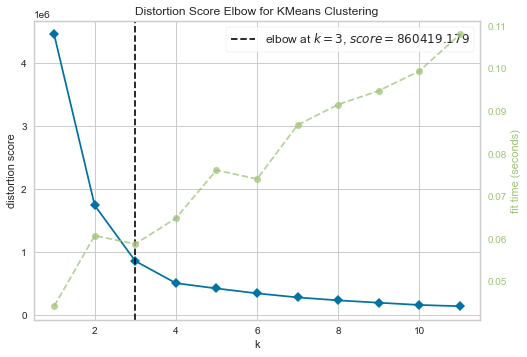

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [2093]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12)).fit(df)
visualizer.show()

In [2094]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(df)

In [2095]:
kmeans.labels_

array([2, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 1, 1, 1, 0, 2,
       1, 2, 2, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 2, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 2, 0, 1, 0, 2, 1, 2, 0,
       1, 0, 2, 0, 1, 1, 0, 1, 2, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0])

In [2096]:
kmeans.inertia_

860419.1790617849

In [2097]:
kmeans.n_iter_

4

In [2098]:
kmeans.cluster_centers_

array([[502.17391304, 388.47826087],
       [265.        , 257.63157895],
       [830.        , 411.25      ]])

In [2099]:
from collections import Counter
Counter(kmeans.labels_)

Counter({2: 12, 1: 38, 0: 46})

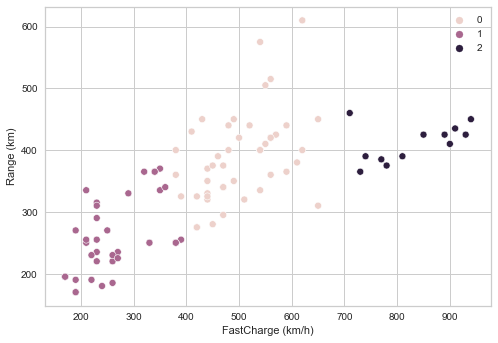

In [2100]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df, x="FastCharge (km/h)", y="Range (km)", hue=kmeans.labels_)
# sns.scatterplot(data=df, x="BodyStyle", y="Efficiency (Wh/km)", hue=kmeans.labels_)
plt.show()

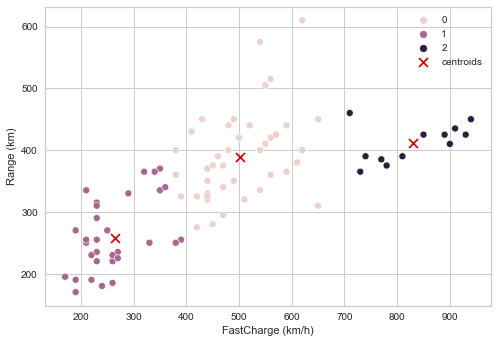

In [2101]:
sns.scatterplot(data=df, x="FastCharge (km/h)", y="Range (km)", hue=kmeans.labels_)
# sns.scatterplot(data=df, x="BodyStyle", y="Efficiency (Wh/km)", hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
            marker="x", c="r", s=80, label="centroids")
plt.legend()
plt.show()

In [2102]:
km_data.insert(8, 'Range-FastCharge category', value = kmeans.labels_)

In [2103]:
km_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 102
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Brand                           96 non-null     object 
 1   Model                           96 non-null     object 
 2   Acceleration 0-100 (s)          96 non-null     float64
 3   TopSpeed (km/h)                 96 non-null     int64  
 4   Acceleration-TopSpeed category  96 non-null     int32  
 5   Range (km)                      96 non-null     int64  
 6   Efficiency (Wh/km)              96 non-null     int64  
 7   FastCharge (km/h)               96 non-null     float64
 8   Range-FastCharge category       96 non-null     int32  
 9   RapidCharge                     96 non-null     int32  
 10  PowerTrain                      96 non-null     int32  
 11  BodyStyle                       96 non-null     int32  
 12  Segment                         96 no

In [2104]:
km_data.head()

,Brand,Model,Acceleration 0-100 (s),TopSpeed (km/h),Acceleration-TopSpeed category,Range (km),Efficiency (Wh/km),FastCharge (km/h),Range-FastCharge category,RapidCharge,PowerTrain,BodyStyle,Segment,Seats,PriceEuro
0,Tesla,Model 3 Long Range Dual Motor,4.6,233,1,450,161,940.0,2,1,3,3,4,5,55480
1,Volkswagen,ID.3 Pure,10.0,160,0,270,167,250.0,1,1,2,1,3,5,30000
2,Polestar,2,4.7,210,2,400,181,620.0,0,1,3,2,4,5,56440
3,BMW,iX3,6.8,180,2,360,206,560.0,0,1,2,6,4,5,68040
4,Honda,e,9.5,145,0,170,168,190.0,1,1,2,1,2,4,32997
